In [37]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [38]:
# 1.set stocks tickets
tickers = ['ARM', 'CART', 'KVYO', 'RDDT', 'ALAB', 'CAVA', 'BIRK', 'NXT']
n_assets = len(tickers)



In [39]:
# 2.set date
start_date = '2023-01-01'
end_date = '2025-11-23'

In [40]:
# 3.download the data
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
data.head()

[*********************100%***********************]  8 of 8 completed


Ticker,ALAB,ARM,BIRK,CART,CAVA,KVYO,NXT,RDDT
Date,,,,,,,,
2023-02-09,NaN,NaN,NaN,NaN,NaN,NaN,30.459999,NaN
2023-02-10,NaN,NaN,NaN,NaN,NaN,NaN,31.010000,NaN
2023-02-13,NaN,NaN,NaN,NaN,NaN,NaN,31.420000,NaN
2023-02-14,NaN,NaN,NaN,NaN,NaN,NaN,30.799999,NaN
2023-02-15,NaN,NaN,NaN,NaN,NaN,NaN,32.680000,NaN


In [41]:
# 4.drop Nan value
data = data.dropna()
print(f"successfully get {len(data)} transaction days。")

successfully get 421 transaction days。


In [42]:
# 5.calculate daily return using pct_change
returns = data.pct_change().dropna()
returns.head()

Ticker,ALAB,ARM,BIRK,CART,CAVA,KVYO,NXT,RDDT
Date,,,,,,,,
2024-03-22,0.091192,0.004117,0.000000,-0.007932,0.002064,-0.033779,0.003432,-0.088025
2024-03-25,0.214286,0.031010,-0.023102,0.013593,0.004267,-0.014599,0.009064,0.300000
2024-03-26,-0.019059,-0.074832,0.012919,-0.039180,-0.000440,0.005458,-0.039492,0.088796
2024-03-27,-0.041497,-0.018287,0.016645,0.015052,0.013925,0.018612,0.023822,-0.113039
2024-03-28,-0.071697,-0.005015,0.004678,0.005392,0.012722,-0.030072,-0.030162,-0.145974


In [43]:
# 6.Calculate Key Matrices (Mapping to Handout 1)
# 6.1 Expected Return Vector mu (Annualized)
# We assume 252 trading days in a year
mu_daily = returns.mean()
mu_annual = mu_daily * 252
mu_annual

Ticker
ALAB    0.876417
ARM     0.204566
BIRK   -0.008655
CART    0.128727
CAVA   -0.039096
KVYO    0.171188
NXT     0.425053
RDDT    1.124762
dtype: float64

In [44]:
# 6.2 Covariance Matrix Sigma (Annualized)
Sigma_daily = returns.cov()
Sigma_annual = Sigma_daily * 252
Sigma_annual

Ticker,ALAB,ARM,BIRK,CART,CAVA,KVYO,NXT,RDDT
Ticker,,,,,,,,
ALAB,0.821738,0.265112,0.069686,0.056330,0.158977,0.189339,0.122280,0.326852
ARM,0.265112,0.429029,0.071415,0.074375,0.135064,0.108077,0.085878,0.190845
BIRK,0.069686,0.071415,0.139162,0.014096,0.079175,0.064769,0.046047,0.061867
CART,0.056330,0.074375,0.014096,0.183468,0.068632,0.029879,0.027935,0.063953
CAVA,0.158977,0.135064,0.079175,0.068632,0.313947,0.086281,0.057511,0.120277
KVYO,0.189339,0.108077,0.064769,0.029879,0.086281,0.322798,0.071606,0.140357
NXT,0.122280,0.085878,0.046047,0.027935,0.057511,0.071606,0.381005,0.073964
RDDT,0.326852,0.190845,0.061867,0.063953,0.120277,0.140357,0.073964,0.732106


In [45]:
# 7. optimization Model Setup

# Objective Function
# min -t*mu'x + 0.5*x'Sigma*x
def objective_function(weights, mu, Sigma, t):
    # Expected Return term (Negative for minimization)
    term1 = -t * np.dot(weights, mu)
    # Variance term (Risk)
    term2 = 0.5 * np.dot(weights.T, np.dot(Sigma, weights))
    return term1 + term2

# Constraints
# 7.1. Budget Constraint: sum(x) = 1
def constraint_sum(weights):
    return np.sum(weights) - 1

# 7.2. Bound Constraints: x >= 0 (No short selling)
# set max_weight = 0.30
max_weight = 0.30
bounds = tuple((0, max_weight) for _ in range(n_assets))

# Constraint dictionary format for scipy
constraints = ({'type': 'eq', 'fun': constraint_sum})

In [46]:
# 8. Tracing the Efficient Frontier
# We scan different risk tolerance parameters 't' from 0 to 2.0
# t=0 corresponds to the Global Minimum Variance Portfolio
t_values = np.linspace(0, 2, 50) 

# 2025 NOV risk_free rate
rf = 0.04


frontier_returns = []
frontier_volatility = []
sharpe_ratios = []
all_weights = []

print("Running Parametric Quadratic Programming optimization...")

for t in t_values:
    # Initial guess (Equal weights)
    init_guess = n_assets * [1. / n_assets,]
    
    # Arguments for the objective function
    args = (mu_annual, Sigma_annual, t)
    
    # Run Optimizer SLSQP
    result = minimize(objective_function, init_guess, args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    if result.success:
        # Extract optimal weights
        w = result.x
        all_weights.append(w)
        
        # Calculate annualized metrics for this portfolio
        # mu_p = mu'x
        ret = np.dot(w, mu_annual)
        # sigma_p^2 = x'Sigma x => volatility is sqrt
        vol = np.sqrt(np.dot(w.T, np.dot(Sigma_annual, w)))
        
        frontier_returns.append(ret)
        frontier_volatility.append(vol)
        
        # Calculate Sharpe Ratio
        # SR = (mu_p - rf) / sigma_p
        sr = (ret - rf) / vol
        sharpe_ratios.append(sr)

Running Parametric Quadratic Programming optimization...


In [47]:
# 9. Selecting the Optimal Portfolio
# Find the index with the maximum Sharpe Ratio
max_sr_idx = np.argmax(sharpe_ratios)

# Retrieve data for the optimal portfolio
optimal_weights = all_weights[max_sr_idx]
opt_ret = frontier_returns[max_sr_idx]
opt_vol = frontier_volatility[max_sr_idx]
best_t = t_values[max_sr_idx]

print("\n" + "="*40)
print(f"Optimization Complete! (Based on Max Sharpe, t={best_t:.2f})")
print("="*40)
print(f"Expected Annual Return:    {opt_ret:.2%}")
print(f"Expected Annual Volatility:{opt_vol:.2%}")
print(f"Maximum Sharpe Ratio:      {sharpe_ratios[max_sr_idx]:.2f}")
print("-" * 40)
print("Optimal Weights Allocation:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"  {ticker}: {weight:.2%}")
print("="*40)


Optimization Complete! (Based on Max Sharpe, t=0.37)
Expected Annual Return:    69.96%
Expected Annual Volatility:49.60%
Maximum Sharpe Ratio:      1.33
----------------------------------------
Optimal Weights Allocation:
  ARM: 24.50%
  CART: 0.00%
  KVYO: 0.00%
  RDDT: 15.50%
  ALAB: 0.00%
  CAVA: 0.00%
  BIRK: 30.00%
  NXT: 30.00%


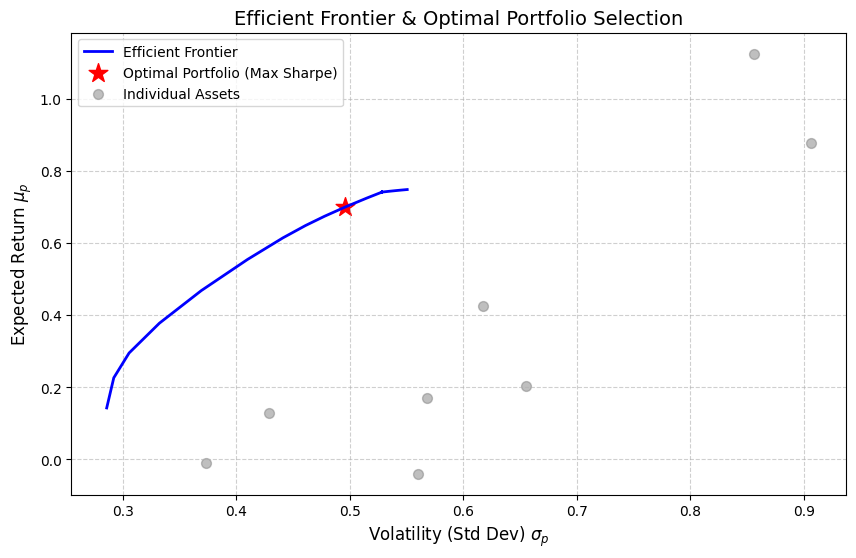

In [48]:
# 10. Visualization (Efficient Frontier)
plt.figure(figsize=(10, 6))

# Plot Efficient Frontier
plt.plot(frontier_volatility, frontier_returns, 'b-', linewidth=2, label='Efficient Frontier')

# Plot Optimal Portfolio
plt.scatter(opt_vol, opt_ret, c='red', s=200, marker='*', label='Optimal Portfolio (Max Sharpe)')

# Plot Individual Assets
asset_vols = np.sqrt(np.diag(Sigma_annual))
asset_rets = mu_annual
plt.scatter(asset_vols, asset_rets, c='gray', s=50, alpha=0.5, label='Individual Assets')

plt.title('Efficient Frontier & Optimal Portfolio Selection', fontsize=14)


plt.xlabel(r'Volatility (Std Dev) $\sigma_p$', fontsize=12)
plt.ylabel(r'Expected Return $\mu_p$', fontsize=12)

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()